In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from tqdm import tqdm
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.0+cu117


In [2]:
#from dataset import TerrainDataset
from datasetIMU import TerrainDatasetIMU
#from pointnet import PointNet
#from pointnetCurv import PointNetCurv

dataset = TerrainDatasetIMU(root='/home/atas/RESEARCH/traversablity_estimation_net/data_imu',train=True)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader
from pointnet_curv import PointnetCurv

train_dataset =  TerrainDatasetIMU(root='/home/atas/RESEARCH/traversablity_estimation_net/data_imu', train=True )
test_dataset = TerrainDatasetIMU(root='/home/atas/RESEARCH/traversablity_estimation_net/data_imu', train=False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

model = PointnetCurv()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()  # Mean Squared Error Loss Function
criterion = torch.nn.L1Loss()  # Mean Absolute Error (L1 Loss Function)

def train(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        optimizer.zero_grad()                   # Clear gradients.
        # reshape to have 1 at the end
        data.pos = data.pos.reshape((data.pos.shape[0], data.pos.shape[1], 1))
        
        logits = model(data.pos, data.face, data.batch)                # Forward pass.
        loss = criterion(logits, data.y)        # Loss computation.
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss


@torch.no_grad()
def test(model, loader):
    model.eval()

    error = 0.0
    for data in loader:
        data.pos = data.pos.reshape((data.pos.shape[0], data.pos.shape[1], 1))
        pred = model(data.pos, data.face, data.batch)
        error += torch.pow((pred - data.y), 2).sum().item()
    
    # convert error to percentage accuracy
    return error

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 01, Loss: 150.3585, MSE: 6.2034
Epoch: 02, Loss: 123.9410, MSE: 4.2049
Epoch: 03, Loss: 117.6712, MSE: 4.3857
Epoch: 04, Loss: 107.5520, MSE: 3.8436
Epoch: 05, Loss: 100.7037, MSE: 4.4525
Epoch: 06, Loss: 98.7457, MSE: 2.4749
Epoch: 07, Loss: 89.5189, MSE: 2.5508
Epoch: 08, Loss: 92.6331, MSE: 3.3234
Epoch: 09, Loss: 87.9140, MSE: 4.6252
Epoch: 10, Loss: 89.8346, MSE: 3.3143
Epoch: 11, Loss: 82.4430, MSE: 4.0735
Epoch: 12, Loss: 81.4983, MSE: 5.8457
Epoch: 13, Loss: 81.1669, MSE: 5.4477
Epoch: 14, Loss: 78.0808, MSE: 3.1558
Epoch: 15, Loss: 74.0006, MSE: 5.1974
Epoch: 16, Loss: 74.7113, MSE: 3.1503
Epoch: 17, Loss: 75.5246, MSE: 3.6364
Epoch: 18, Loss: 73.7012, MSE: 2.3296
Epoch: 19, Loss: 68.3890, MSE: 4.9366
Epoch: 20, Loss: 70.9290, MSE: 3.2496
Epoch: 21, Loss: 69.8130, MSE: 6.0906
Epoch: 22, Loss: 67.1710, MSE: 4.2626
Epoch: 23, Loss: 68.7204, MSE: 5.2557
Epoch: 24, Loss: 65.2240, MSE: 2.9139
Epoch: 25, Loss: 64.4743, MSE: 7.8103
Epoch: 26, Loss: 63.8007, MSE: 3.6517
Epoch: 

Text(0.5, 0, 'epochs')

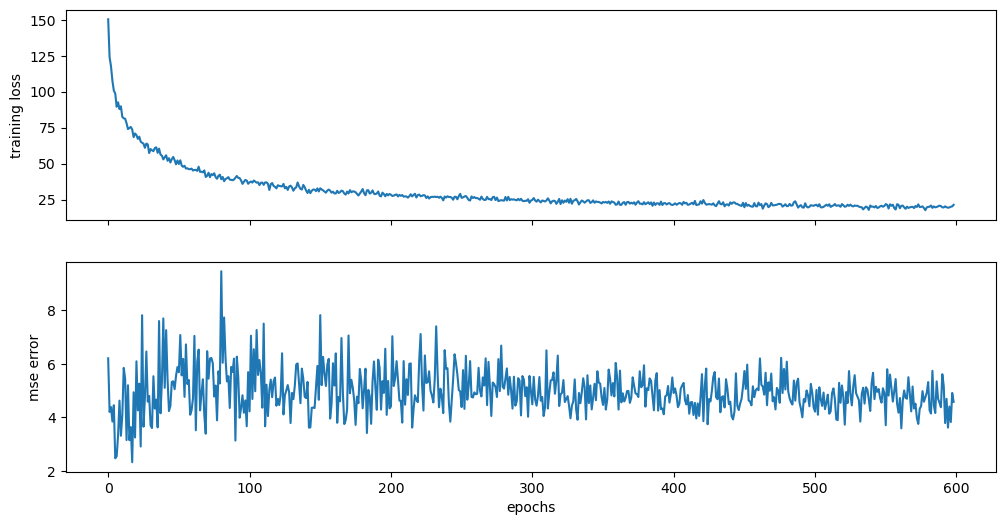

In [4]:
train_loss=[]
test_mse=[]

# Save every 10th epoch model.
for epoch in range(1, 600):
    loss = train(model, optimizer, train_loader)
    mse = test(model, test_loader)
    if epoch % 50 == 0:
        torch.save(model.state_dict(), f'epoch_{epoch}.pt')
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, MSE: {mse:.4f}')
    train_loss.append(loss)
    test_mse.append(mse)
    
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(train_loss)
ax1.set_ylabel("training loss")
ax2.plot(test_mse)
ax2.set_ylabel("mse error")
ax2.set_xlabel("epochs")    

In [5]:
visual_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model
# print curdir()
print(os.getcwd())

net = PointnetCurv()
net.load_state_dict(torch.load('/home/atas/RESEARCH/traversablity_estimation_net/weights/epoch_250.pt'))
net.eval()

error = 0.0
for data in visual_test_loader:
 
    inputs, labels = data.pos, data.y
    inputs = inputs.reshape((inputs.shape[0], inputs.shape[1], 1))
    outputs = net(inputs, data.face, data.batch)
    
    error += torch.pow((outputs - data.y), 2).sum().item()
    outputs = outputs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

error = error / len(visual_test_loader)
print("MSE: " + str(error))    


/home/atas/RESEARCH/traversablity_estimation_net/scripts


FileNotFoundError: [Errno 2] No such file or directory: '/home/atas/RESEARCH/traversablity_estimation_net/weights/epoch_250.pt'